# Download the Data

In [1]:
# Install tqdm, a Python library for creating progress bars
!pip3 install tqdm

In [2]:
#%matplotlib inline  # Enable inline plotting within the notebook

#%matplotlib inline 
#Essential library imports for data handling and visualization
import os
import tarfile
import urllib.request  # Updated library for downloading files
import shutil
import json
import random
import numpy as np
import boto3  # AWS SDK for Python
import sagemaker

#tqdm for displaying progress bars during downloads/operations
from tqdm import tqdm 
#Updated import for image retrieval
from sagemaker import image_uris 
from matplotlib import pyplot as plt

#URLs for downloading the Oxford Pets dataset (images and annotations)
urls = [
    "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
    "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz",
]

#Function to download and extract the dataset from the provided URLs
def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split("/")[-1]  #Get the filename from the URL

        #Check if the file is already downloaded
        if target_file not in os.listdir(download_dir): 
            print("Downloading", url) #Indicate download progress to the user

            #Download the file using urllib.request
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))

            #Extract the downloaded tar.gz file
            with tarfile.open(os.path.join(download_dir, target_file)) as tf:
                tf.extractall(data_dir)
        else:
            print("Already downloaded", url) #Notify if the file is already available

#Function to process annotations and associate image names with class labels
def get_annotations(file_path):
    annotations = {}  # Dictionary to store annotations

    with open(file_path, "r") as f:
        rows = f.read().splitlines()  # Read and split annotation lines

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(" ")  # Parse annotation row
        class_name = "_".join(image_name.split("_")[:-1])  # Extract class name from image name
        image_name = image_name + ".jpg"  # Add the jpg extension to the image name
        annotations[image_name] = class_name  # Store the annotation

    return annotations, i + 1  # Return the annotations and the total count

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# Create a 'data' directory if it doesn't exist
if not os.path.isdir("data"): 
    os.mkdir("data") 

# Download and extract the Oxford Pets dataset to the 'data' directory
download_and_extract("data", ".") 

In [4]:
# Get training annotations and their count from 'trainval.txt'
train_annotations, _ = get_annotations("data/annotations/trainval.txt") 

# Get test annotations and their count from 'test.txt'
test_annotations, _ = get_annotations("data/annotations/test.txt")

# Print the number of training annotations
print(len(train_annotations)) 

# Print the number of test annotations
print(len(test_annotations)) 

3680
3669


In [5]:
# Create a dictionary to store all annotations
all_annotations = {}  

# Iterate over the train_annotations dictionary
for key, value in train_annotations.items(): 
    # Add the key-value pair to the all_annotations dictionary
    all_annotations[key] = value  

# Iterate over the test_annotations dictionary
for key, value in test_annotations.items():  
    # Add the key-value pair to the all_annotations dictionary
    all_annotations[key] = value

In [6]:
# Create empty dictionaries for new train and test annotations
train_annotations = {}  
test_annotations = {}  

# Iterate over all annotations
for key, value in all_annotations.items(): 
    # Randomly assign to test set with 20% probability
    if random.randint(0, 99) < 20: 
        test_annotations[key] = value 
    # Otherwise, assign to train set
    else:
        train_annotations[key] = value 

In [7]:
# Get the number of training images by creating a list of the keys (image names) in the train_annotations dictionary
train_count = len(list(train_annotations.keys()))

# Get the number of test images by creating a list of the keys (image names) in the test_annotations dictionary
test_count = len(list(test_annotations.keys()))

# Print the number of training images
print(train_count)

# Print the number of test images
print(test_count)

5802
1547


# Visualize Data

In [8]:
classes = list(all_annotations.values())

classes = list(set(classes))

print(classes)
print('\nNum of classes:', len(classes))

['chihuahua', 'havanese', 'saint_bernard', 'boxer', 'Egyptian_Mau', 'shiba_inu', 'Persian', 'miniature_pinscher', 'British_Shorthair', 'Abyssinian', 'Maine_Coon', 'german_shorthaired', 'wheaten_terrier', 'yorkshire_terrier', 'leonberger', 'staffordshire_bull_terrier', 'Ragdoll', 'scottish_terrier', 'basset_hound', 'Birman', 'Russian_Blue', 'pomeranian', 'newfoundland', 'great_pyrenees', 'Siamese', 'american_bulldog', 'Bombay', 'beagle', 'japanese_chin', 'Sphynx', 'american_pit_bull_terrier', 'pug', 'Bengal', 'english_cocker_spaniel', 'keeshond', 'samoyed', 'english_setter']

Num of classes: 37


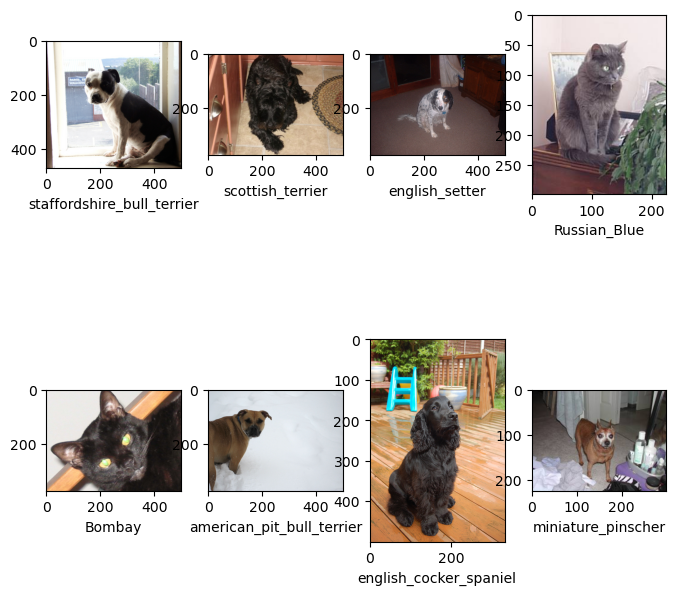

In [9]:
plt.figure(figsize=(8, 8))

train_images = list(train_annotations.keys())

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    image = train_images[random.randint(0, train_count - 1)]
    plt.imshow(plt.imread(os.path.join('data/images/', image)))
    plt.xlabel(train_annotations[image])
plt.show()

# SageMaker Setup

In [10]:
import sagemaker
from sagemaker import image_uris  # Import the image_uris module for getting container URIs
import boto3  # Ensure boto3 is imported for AWS interactions

# Get the IAM role associated with the current SageMaker notebook
role = sagemaker.get_execution_role()

# Specify the S3 bucket where you will store training data and model artifacts
bucket_name = "petsdataod"

# Get the URI of the latest object detection Docker image from SageMaker's registry
# (Updated to use image_uris)
training_image = image_uris.retrieve(framework="image-classification", region=boto3.Session().region_name, version="latest")

# Print the training image URI for confirmation
print(training_image) 

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:1


In [12]:
folders = ['train', 'train_lst', 'validation', 'validation_lst']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [13]:
def prepare_data(annotations, key='train'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            shutil.copy(os.path.join('data/images/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()

In [14]:
prepare_data(train_annotations, 'train')

100%|██████████| 5802/5802 [00:02<00:00, 2497.10it/s]


In [15]:
prepare_data(test_annotations, 'validation')

100%|██████████| 1547/1547 [00:00<00:00, 2180.06it/s]


# Uploading Data to S3

In [24]:
# Create a SageMaker session to interact with SageMaker resources
sess = sagemaker.Session()  

print("Uploading data..")

# Upload training images to S3
s3_train_path = sess.upload_data(
    path="train", bucket=bucket_name, key_prefix="train"
)
print("Training images uploaded")

# Upload training annotations to S3
s3_train_lst_path = sess.upload_data(
    path="train_lst", bucket=bucket_name, key_prefix="train_lst"
)
print("Training lst uploaded")

# Upload validation images to S3
s3_validation_path = sess.upload_data(
    path="validation", bucket=bucket_name, key_prefix="validation"
)
print("Validation images uploaded")

# Upload validation annotations to S3
s3_validation_lst_path = sess.upload_data(
    path="validation_lst", bucket=bucket_name, key_prefix="validation_lst"
)
print("Validation lst uploaded")

Uploading data..
Training images uploaded
Training lst uploaded
Validation images uploaded
Validation lst uploaded


In [25]:
#Retrieve the S3 Path to Validation Annotations

s3_validation_annotation_path

's3://petsdataod/validation_lst'

# SageMaker Estimator

In [31]:
# Create a SageMaker estimator object, which encapsulates the training job configuration and execution.
model = sagemaker.estimator.Estimator(
    # Retrieve the image URI for the SageMaker image classification algorithm using the latest version 
    # by setting 'version' to None, and specify that it's for training.
    image_uri=image_uris.retrieve(framework="image-classification", region=boto3.Session().region_name, version="latest"),  
    # The IAM role that SageMaker will assume to access training and model data.
    role=role,  
    # The number of EC2 instances to use for training (in this case, 1 instance).
    instance_count=1,  
    # The type of EC2 instance to use for training. 'ml.p3.2xlarge' is a GPU-accelerated instance suitable for deep learning.
    instance_type="ml.p3.2xlarge",  
    # The size of the Amazon Elastic Block Store (EBS) volume to use for storing training data (100 GB in this case).
    volume_size=100,  
    # The maximum runtime for the training job in seconds (36,000 seconds, or 10 hours).
    max_run=36000,  
    # The method by which SageMaker will provide input data to the training container. 'File' indicates that data will be loaded from Amazon S3.
    input_mode="File",  
    # The S3 path where the model artifacts (trained model, checkpoints, etc.) will be stored after training.
    output_path="s3://petsdataod/output",  
    # The SageMaker Session object, which provides convenient methods for interacting with SageMaker resources.
    sagemaker_session=sess,  
)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


# Hyperparameters

In [32]:
# Set hyperparameters for the SageMaker object detection estimator. 
# These hyperparameters define the configuration of the model's architecture and training process.
model.set_hyperparameters(
    # Number of layers in the convolutional neural network (CNN) architecture of the model. 
    # In this case, 18 layers are used, indicating a relatively deep network.
    num_layers=18,  

    # Number of distinct object classes that the model is trained to detect (e.g., dog, cat, bird). 
    # There are 37 classes in the Oxford Pets dataset.
    num_classes=37,  

    # Flag to indicate whether the model should use pre-trained weights. 
    # 1 means the model will start with weights learned from ImageNet, a large-scale image dataset. 
    # This can significantly speed up training.
    use_pretrained_model=1,  

    # Number of images processed in each training iteration. 
    # Smaller mini-batch sizes generally require less memory but might take longer to train.
    mini_batch_size=32,  

    # Size to which input images will be resized before feeding them into the model. 
    # 224x224 is a common size for image classification models.
    resize=224,  

    # Number of complete passes through the entire training dataset during the training process. 
    # Increasing epochs can help improve model accuracy but might lead to overfitting.
    epochs=7,  

    # Initial step size used by the optimizer to update model weights during training. 
    # A smaller learning rate leads to more gradual updates and potentially a more stable training process.
    learning_rate=0.001,  

    # Type of data augmentation to apply during training. 
    # 'crop_color_transform' suggests a combination of cropping and color transformations.
    # Data augmentation helps prevent overfitting by introducing variations to the training data.
    augmentation_type="crop_color_transform",  

    # Number of training examples (images) in your dataset. 
    # This is used to calculate the total number of training steps across all epochs.
    num_training_samples=train_count, 
)

# Data Channels

In [35]:
# Create SageMaker training data channels for images and annotations, using the correct channel names
train_data = sagemaker.inputs.TrainingInput(
    s3_train_path, 
    distribution="FullyReplicated",
    content_type="application/x-image", 
    s3_data_type="S3Prefix" 
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_path, 
    distribution="FullyReplicated",
    content_type="application/x-image", 
    s3_data_type="S3Prefix"
)

# Create SageMaker training data channels for annotations, using the correct channel names
train_annotation = sagemaker.inputs.TrainingInput(
    s3_train_lst_path, 
    distribution="FullyReplicated",
    content_type="application/x-image",  
    s3_data_type="S3Prefix"
)
validation_annotation = sagemaker.inputs.TrainingInput(
    s3_validation_lst_path, 
    distribution="FullyReplicated",
    content_type="application/x-image",  
    s3_data_type="S3Prefix"
)

# Create a dictionary mapping channel names to SageMaker data channel objects, using the correct channel names
data_channels = {
    "train": train_data,               
    "train_lst": train_annotation,    
    "validation": validation_data,     
    "validation_lst": validation_annotation, 
}


data_channels

{'train': <sagemaker.inputs.TrainingInput at 0x7f2ed62a6ef0>,
 'train_lst': <sagemaker.inputs.TrainingInput at 0x7f2ed62a6dd0>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7f2ed62a7f10>,
 'validation_lst': <sagemaker.inputs.TrainingInput at 0x7f2ed62a5c00>}

# Model Training

In [36]:
# Start the training job by calling fit() on the estimator
model.fit(inputs=data_channels, logs=True) 

INFO:sagemaker:Creating training-job with name: image-classification-2024-07-02-01-34-17-108


2024-07-02 01:34:17 Starting - Starting the training job...
2024-07-02 01:34:42 Starting - Preparing the instances for training...
2024-07-02 01:35:15 Downloading - Downloading input data......
2024-07-02 01:36:15 Downloading - Downloading the training image.........
2024-07-02 01:37:30 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Tue Jul  2 01:37:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usag

# Deploy Model

In [37]:
# Deploy the trained model
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge') 

# Print a confirmation message
print('\nModel deployed!') 

INFO:sagemaker:Creating model with name: image-classification-2024-07-02-01-42-56-626
INFO:sagemaker:Creating endpoint-config with name image-classification-2024-07-02-01-42-56-626
INFO:sagemaker:Creating endpoint with name image-classification-2024-07-02-01-42-56-626


---------!
Model deployed!


# Predictions

In [38]:
import os

# Specify the directory containing validation images
image_dir = "validation"

# Create a list of all image filenames in the validation directory that end with '.jpg'
images = [x for x in os.listdir(image_dir) if x[-3:] == "jpg"]

# Print the total number of validation images found
print(len(images)) 

1547


In [39]:
# Set the content type for the deployed SageMaker model
deployed_model.content_type = "image/jpeg" 

In [66]:
import os
import json

# Select an index for an image in the validation set
index = 120

# Get the path to the selected image file
image_path = os.path.join(image_dir, images[index])

# Open the image file in binary read mode
with open(image_path, "rb") as f:
    # Read the image data as bytes
    b = bytearray(f.read())

# Make a prediction on the image using the deployed model
# (This assumes 'deployed_model' was created in a previous cell)
results = deployed_model.predict(b)


# Since the model is not object detection based the output will be a list rather than dict 
results = json.loads(results)


# Extract the predicted class label (the class with the highest probability)
predicted_label_index = np.argmax(results)  

# Get the predicted class label string using the 'classes' list
predicted_class_label = classes[predicted_label_index] 

print(f"Predicted class label: {predicted_class_label}")

Predicted class label: havanese


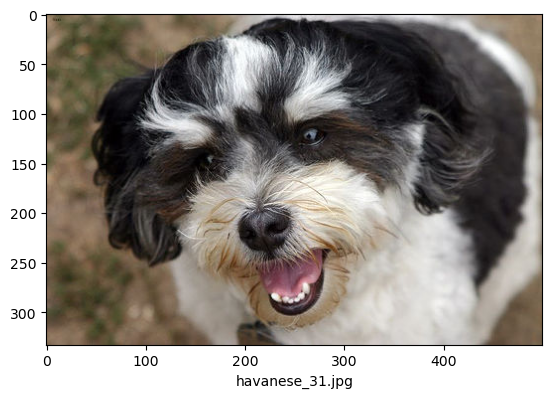

In [67]:
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()


Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)